In [9]:
from hydra import compose, initialize
from hydra.utils import instantiate

# Config files are in /config/?
model_config = "imagenet_googlenet"  # /config/model
dataset_config = "imagenet_val"  # /config/dataset

with initialize(config_path="config"):
    cfg = compose(
        config_name="config",
        overrides=[f"model={model_config}", f"dataset={dataset_config}"],
    )
    model_config = cfg.model
    model = instantiate(model_config.instance)
    if "state_dict_path" in model_config:
        import torch

        model.load_state_dict(torch.load(model_config.state_dict_path))
    model = model.eval()

    from foolbox.models.pytorch import PyTorchModel

    model = PyTorchModel(
        model=model,
        preprocessing=model_config.preprocessing,
        device="cpu",
        bounds=(0, 1),
    )

    from torch.utils.data import DataLoader

    loader = DataLoader(
        dataset=instantiate(cfg.dataset),
        batch_size=1,
        shuffle=False,
        num_workers=8,
    )


In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from runner import Runner


runner = Runner(model, loader)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
runner.run_accuracy()

In [ ]:
import os
import torch

results_folder = "results/imagenette_train/googlenet/"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

std = torch.arange(0, 0.011, 0.001)
runner.run(results_folder + "0:.01.pt", std)


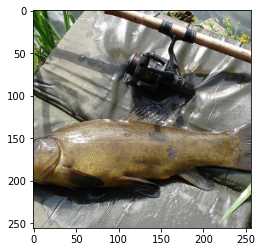

In [19]:
from masker import Masker

x, y = runner.get_one_batch()
plt.imshow(x[0].permute(1, 2, 0))
